In [148]:
import os
import sys
import math
#from liblibra_core import * 
#from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma

In [93]:
def profiler(func):
    # Decorater to profile the code, use for development
    # Turn off profiler by commenting line 1 of this code block.
    def wrapper(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        retval = func(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return(retval)
    return(wrapper)

#@profiler
def MIW_Forces(X, params, P = 0, Rsq = 0, Pi = 0, dPijk = 0, ddPijk = 0, dPik = 0, ddPik = 0, gik = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        params: Dictionary, elements use are b=kernel width.
        OPTIONAL: Include matrices of correct shape for force computation *Avoids ~10 allocs per MD step*
    Returns:
        forces: Python list of the MIW forces, for addition to the classical ones in Nuclear object.f prior to propagation.
    """
    # D is dimensionality of space, J is number of particles per world, N is number of worlds.
    # b is kernel width parameter, and ktype is the type of kernel (exp or gaussian for now)
    # M is the matrix of size X.shape containing masses for the particles at the relevant entry M[i][k]
    # Notation in all functions consistent with 10.1103/PhysRevE.97.053311 and 10.1103/PhysRevX.4.041013
    N = len(X) 
    b = params["b"]
    D = params["D"]
    J = params["J"]
    M = params["M"]
    ktype = params["ktype"]
    
    if type(P) == int:
        # Initializes all needed multidims with correct shape
        # i/j loop over worlds i.e 1->N in conventional sense
        # k loops over coords i.e. 1->J*D in conventional sense
        Rsq   = np.zeros( (N, N) )
        P     = np.zeros( (N, N) )
        F     = np.zeros( (N, J*D) )
        Pi    = np.zeros( (N) )
        dPijk = np.zeros( (N, N, J*D) )
        dPik  = np.zeros( (N, J*D) )
        ddPijk= np.zeros( (N, N, J*D) )
        ddPik = np.zeros( (N, J*D) )
        gik   = np.zeros( (N, J*D) )

        
    #Compute Rsq matrix
    Rsq = Compute_Rsquared(X, Rsq)

    #Populate P matrix for P[i][j]
    P = Compute_P(X, Rsq, ktype, P)

    #Populate Pi matrix for Pi[i]
    for i in range(N):
        Pi[i] = Compute_Pi(X, P, i)


    #3 index terms computed together to minimize python looping
    #Populate dPijk matrix for dPijk[i][j][k]
    #Populate ddPijk matrix for ddPijk[i][j][k]
    for i in range(N):
        for k in range(J*D):
            for j in range(N):
                dPijk[i][j][k]  = Compute_dPijk(X, Rsq, i, j, k, b, P, ktype)
                ddPijk[i][j][k] = Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype)

                #2 index terms computed in this same loop to minimize python loops further
                #Populate dPik matrix for dPik[i][k]
                #Populate ddPik matrix for ddPik[i][k]
                if j == range(N)[-1]:
                    #Works because for given i, k, once last j is filled out, 
                    #Pijk holds all j values for a given i, k
                    dPik[i][k]  = Compute_dPik(X, i, k, b, dPijk, ktype)
                    ddPik[i][k] = Compute_ddPik(X, i, k, b, ddPijk, ktype)
                    gik[i][k]   = Compute_gik(X, i, k, b, dPik, Pi, ktype) 
    
    if ktype.lower() == "gaussian":         
        # 1D has significantly easier computation.
        if D == 1:
            # print("Using simplified forces for D = 1")
            for n in range(N):
                for l in range(J*D):
                    F[n][l] = -1 * ( ( 2 * gik[n][l] * ( -1.0/(Pi[n]**2) * dPik[n][l]**2 + 1.0/Pi[n] * ddPik[n][l] ) ) )

                    for i in range(N):
                        if i != n:
                            F[n][l] += -1 * 2 * gik[i][l] * ( 1.0/(Pi[i]**2) * dPijk[i][n][l]*dPik[i][l] 
                                                       - 1.0/Pi[i] * ddPijk[i][n][l] )
        # General case for D != 1                    
        else:
            for n in range(N):
                for l in range(J*D):
                    F[n][l] = -1 * ( ( 2 * gik[n][l] * ( -1.0/(Pi[n]**2) * dPik[n][l]**2 + 1.0/Pi[n] * ddPik[n][l] ) ) )

                    for i in range(N):
                        if i != n:
                            F[n][l] += -1 * 2 * gik[i][l] * ( 1.0/(Pi[i]**2) * dPijk[i][n][l]*dPik[i][l] 
                                                       - 1.0/Pi[i] * ddPijk[i][n][l] )
                    for k in range(J*D):
                        if k != l:
                            res = 0
                            for j in range(N):
                                res += X[n][k]-X[j][k] * dPijk[n][j][l]

                            F[n][l] += -1 * 2 * gik[n][k] * ( -1.0/(Pi[n]**2) * dPik[n][k]*dPik[n][l] 
                                                            - 2.0/(b**2 * Pi[n]) * res ) 

                    for i in range(N):
                        if i != n:
                            for k in range(J*D):
                                if k != l:
                                    F[n][l] += -1 * 2 * gik[i][k] * ( 1.0/(Pi[i]**2) * dPijk[i][n][k] * dPik[i][l]
                                                                    + 2.0/(b**2 * Pi[i]) * (X[i][k] - X[n][k]) * dPijk[i][n][l] )    
    elif ktype.lower() == "exponential": 
        for n in range(N):
            for l in range(J*D):
                #Compute dU/dx_n^l
                F[n][l] += -1 * 2*gik[n][l]*( -1/Pi[n]**2 * dPik[n][l]**2 + 1/Pi[n]*ddPik[n][l] )
                
                for i in range(N):
                    if i != n:
                        F[n][l] += -1 * 2*gik[i][l]*( 1/Pi[i]**2 * dPijk[i][n][l] * dPik[i][l] - 1/Pi[i] * ddPijk[i][n][l] )
                for k in range(J*D):
                    if k != l:
                        res = 0
                        for j in range(N):
                            res += (X[n][k]-X[j][k])/np.sqrt(Rsq[n][j]) * (1/np.sqrt(Rsq[n][j]) + 1/b) * dPijk[n][j][l]             
                                                                         
                        F[n][l] += -1 * 2*gik[n][k]*( -1/Pi[n]**2 *dPik[n][k]*dPik[n][l] - 1/Pi[n] * res )
                for i in range(N):
                    if i != n:
                        for k in range(J*D):
                            if k != l:
                                F[n][l] += -1 * 2*gik[i][k]*( 1/Pi[i]**2 *dPijk[i][n][k]*dPik[i][l] + 1/Pi[i] * (X[i][k]-X[n][k])/np.sqrt(Rsq[i][n]) * ( 1/np.sqrt(Rsq[i][n]) + 1/b )*dPijk[i][n][l] )
    
    U = Compute_MIW_Potential(X, b, gik, M, ktype)                                                    
    return(F, U)

def Compute_Rsquared(X, Rsq = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        OPTIONAL Rsquared: Pass the last step's Rsquared matrix to avoid allocation cost at every step.
    Returns:
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
    """
    if type(Rsq) == int:
        Rsq = np.zeros((len(X), len(X)))
    else:
        pass
    
    for i in range(len(Rsq)):
        for j in range(len(Rsq[0])):
            Rsq[i][j] = np.inner(X[i]-X[j], X[i]-X[j])
    return(Rsq)

def  Compute_P(X, Rsq, ktype, P = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
        OPTIONAL, P: Passes P from last step to avoid reallocations at every dynamics step.
        ktype: Type of kernel being used, exponential or gaussian
    Returns:
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
    """
    if type(P) == int:
        P = np.zeros((len(X), len(X)))

    if ktype.lower() == 'gaussian':    
        for i in range(len(P)):
            for j in range(len(P)):
                P[i][j] = Compute_Pij(X, i, j, Rsq, b, ktype)
                
    # This is unnecessary since ktype is passed, but I'm just leaving it in for now
    # in case I separated these for some reason not immediately clear.
    elif ktype.lower() == 'exponential':
        for i in range(len(P)):
            for j in range(len(P)):
                P[i][j] = Compute_Pij(X, i, j, Rsq, b, ktype)
                
    
    return(P)
    
    
def Compute_Pij(X, i, j, Rsq, b, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        j: Index to be summed over in computation of P_i
        b: Kernel width parameter
        ktype: Kernel type ("gaussian" or "exponential")
        rijsquared: Sum of squared distances between coords of worlds i, j, $r_{ij}^2 = \Sigma_{k}( r_{ij}^k )^2$
    Returns:
        Pij: Density contribution of particle j at the position of particle i (Used for forces)
    """
    N = len(X)
    # Gaussian Kernel Computation
    
    if ktype.lower() == "gaussian":
        return ( 1 / ( N * ( np.sqrt(np.pi)*b )**D )  ) * np.exp( - Rsq[i][j] / b**2 )
    elif ktype.lower() == "exponential":
        return ( gamma(D/2) / 2*N * math.factorial(D-1) * (np.sqrt(np.pi)* b )**D * np.exp( - np.sqrt(Rsq[i][j]) / b )  )
    

    
def Compute_Pi(X, P, i):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        P: Promputed matrix with elements computed by Compute_Pij() function. P[i][j] = Compute_Pij(X, i, j, ...)
        i: Index of the world being computed for
    Returns:
        Pi: $\Sigma_{j} P_{ij}$
    """
    N = len(X)
    res = 0
    
    for j in range(N):
        res+= P[i][j]
        
    return(res)
        
        
def Compute_dPijk(X, Rsq, i, j, k, b, P,  ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix with Rsq[i][j] standard inner product of (X[i][j], X[i][j])
        i: Index of the world being computed for
        j: Index to be summed over in computation of dP_i
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential")
        Pij: Value for Pij precomputed and stored in the P matrix. Pij = P[i][j]
    """
    
    rij_k = X[i][k] - X[j][k]
    
    if ktype.lower() == "gaussian":
        return( -(2.0/b**2) * rij_k * P[i][j] )
    elif ktype.lower() == "exponential":
        if i != j:
            return (  -1/b * ( (X[i][k] - X[j][k]) / Rsq[i][j] ) * P[i][j]  )
        else:
            return ( 0.0 ) 
    else:
        return("Error, kernel type not yet implemented.")
    
# Remove ktype later
def Compute_dPik(X, i, k, b, dPijk, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential") 
    Returns:
        res: dP_i^k, Sum over worlds j, of dPijk. Needed for force computation.
    """
    res = 0
    for j in range(len(X)):      
        res += dPijk[i][j][k]

    return(res)

def Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix with Rsq[i][j] standard inner product of (X[i][j], X[i][j])
        i: Index of the world being computed for
        j: Index to be summed over in ddP_i
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        res: ddP_ij^k. Needed for force computations.
    """
    rij_k = X[i][k] - X[j][k]
    if ktype.lower() == "gaussian":
        return( -2.0/b**2 * ( 1 - (2.0/b**2) * rij_k**2 ) * P[i][j] )
    elif ktype.lower() == "exponential":
        if i != j:
            return( -1/(np.sqrt(Rsq[i][j]) * b) * ( 1 - (rij_k**2)/Rsq[i][j] - 1/b * (rij_k**2)/np.sqrt(Rsq[i][j]) ) * P[i][j] ) 
        else:
            return ( 0 )

#Remove ktype later
def Compute_ddPik(X, i, k, b, ddPijk, ktype):
    res = 0
    for j in range(len(X)):
        res += ddPijk[i][j][k]
    
    return(res)
    
def Compute_gik(X, i, k, b, dPik, Pi, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        dPik: Matrix with dPik[i][k] elements for gik[i][k] computation
        Pi: Matrix with Pi[i] elements for gik[i][k] computation
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        gik[i][k] value needed for computation of MIW forces and potential
    """
    return( .5 * dPik[i][k] / Pi[i] )

def Compute_MIW_Potential(X, b, gik, M, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        b: Kernel width parameter
        gik: Matrix containing gik elements as gik[i][k]
        Mik: Matrix containing mass for the particle corresponding to X[i][k] as Mik[i][k]
        ktype: Kernel type ("gaussian" or "exponential")
    """
    res = 0
    for i in range(len(X)):
        for k in range(len(X[0])):
            res += .5 * 1/M[i][k] * gik[i][k] ** 2
    return(res)
        
def Populate1DUniform(N, spacing):
    X = np.zeros((N, 1))
    for i in range(N):
        X[i][0] = -(N-1)/2.0 * spacing + i*spacing
    return(X)


def Write_Frame_To_XYZ(X, D, filename):
    array = []
    if D == 1:
        for i in X:
            array.append([i[0], 0, 0])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("X" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
    return()

#Don't pass filename if you don't want to write to a file
def verlet(X, V, params, dt, steps, filename = 0):
    F = MIW_Forces(X, params)
    for i in range(steps):
        X = X + V * dt + .5 * np.divide(F, M) * dt * dt
        V = V + .5 * np.divide(F, M) * dt
        F = MIW_Forces(X, params)
        V = V + .5 * np.divide(F, M) * dt
        
        if type(filename) != int:
            Write_Frame_To_XYZ(X, 1, filename)


## Sets up system for testing simple 1D, 1 particle per world things (GAUSSIAN).

In [264]:
N = 2
J = 1
D = 1
b = .5
spacing = 1

# Populate a simple uniform distirbution centered on origin for J = D = 1
# Populate the masses with simply all Mij = 1
X = Populate1DUniform(N, spacing)
M = np.zeros( X.shape )
M += 1.0
V = np.zeros( X.shape )

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


F, U = MIW_Forces(X, params)
print(F, U)
dt = .2
steps = 100

#filename = "traj.xyz"
#os.system("rm %s" % filename)
#verlet(X, V, params, dt, steps, filename)


[[ 0.84651209]
 [-0.84651209]] 0.005176059980807066


## Testing for same params as above (EXPONENTIAL).

In [263]:
N = 2
J = 1
D = 1
b = .5
spacing = 1

# Populate a simple uniform distirbution centered on origin for J = D = 1
# Populate the masses with simply all Mij = 1
X = Populate1DUniform(N, spacing)
M = np.zeros( X.shape )
M += 1.0
V = np.zeros( X.shape )
print(X)
params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
}


F, U = MIW_Forces(X, params)
print(F, U)

dt = .2
steps = 100

#filename = "traj.xyz"
#os.system("rm %s" % filename)
#verlet(X, V, params, dt, steps, filename)

[[-0.5]
 [ 0.5]]
[[-0.20024867]
 [ 0.20024867]] 0.01420933661861104


# Generating the Potential as a function of x1-x2

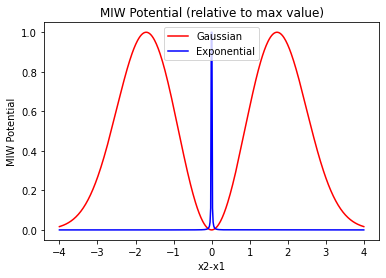

In [262]:
x1 = 0
start = -4
steps = 500
x2 = np.linspace(-start, start, steps)

b = 2

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


X = np.zeros( ( 2 , 1 ) )

X[0][0] = x1
GaussianPotentials = np.zeros( (len(x2), 1) )
ExponentialPotentials = np.zeros( (len(x2), 1) )
for i in range(len(x2)):
    X[1][0] = x2[i]
    params["ktype"]="gaussian"
    F, U = MIW_Forces(X, params)
    GaussianPotentials[i] = U
    params["ktype"]="exponential"
    F, U = MIW_Forces(X, params)
    ExponentialPotentials[i] = U

plt.figure(1)
plt.title("MIW Potential (relative to max value)")
plt.xlabel("x2-x1")
plt.ylabel("MIW Potential")
plt.plot(x2, GaussianPotentials/max(GaussianPotentials), color = 'red', label = 'Gaussian')
plt.plot(x2, ExponentialPotentials/max(ExponentialPotentials), color ='blue', label = 'Exponential')
plt.legend()